# Definimos el directorio de trabajo.


In [1]:
from google.colab import drive

# Attempting to mount to the given path
drive.mount('/content/drive/')
path='/content/drive/MyDrive/Catsvsdogs/catsvsdogs/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Cargamos las librerías.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: ', {device})

Using device:  {device(type='cpu')}


# Preprocesamiento de imágenes.


In [4]:
transforms = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Dividimos la muestra en conjuntos de entrenamiento, prueba y validación.

In [5]:
full_dataset = datasets.ImageFolder(root=path,transform=transforms)
TRAIN_SIZE =  int(len(full_dataset) * 0.8)
VAL_SIZE = int(len(full_dataset) * 0.1 )
TEST_SIZE = int(len(full_dataset) * 0.1+1 )
BATCH_SIZE = 16
training_set, val_set,test_set =random_split(full_dataset,[TRAIN_SIZE,VAL_SIZE,TEST_SIZE])

In [6]:
training_loader = DataLoader(dataset=training_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader =DataLoader(dataset=test_set, batch_size=BATCH_SIZE,shuffle=True)

# Identificamos las etiquetas de las impagenes.


In [7]:
!ls /content/drive/MyDrive/Catsvsdogs/catsvsdogs/

cats  dogs


# Exploramos las impagenes.


La imagen muestreada representa un:dog


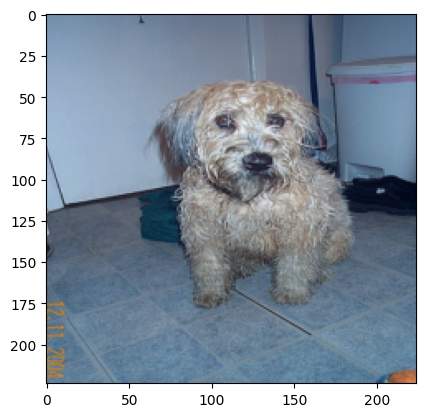

In [8]:
import numpy as np
import matplotlib.pyplot as plt
categories=['cat','dog']
def plot_figure(image):
  plt.imshow(image.permute(1,2,0))
  plt.show()

rnd_sample_idx = np.random.randint(TEST_SIZE)
print(f'La imagen muestreada representa un:{categories[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image-image.min())/(image.max()-image.min())
plot_figure(image)

# Definimos la función para el cálculo de precisión.

In [9]:
def accuracy(model, loader):
  num_correct =0
  num_total = 0
  model.eval()
  model = model.to(device = device)
  with torch.no_grad():
    for(xi,yi) in loader:
      xi=xi.to(device=device,dtype=torch.float32)
      yi=yi.to(device=device, dtype= torch.long)
      scores = model(xi)
      _,pred = scores.max(dim=1)
      num_correct += (pred == yi.squeeze()).sum()
      num_total += pred.size(0)

  return float(num_correct)/num_total


# Definimos el loop de entrenamiento.


In [10]:
def train(model, optimiser, epochs =100):
  model = model.to(device=device)
  for epoch in range(epochs):
     for (xi,yi) in training_loader:
      model.train()
      xi = xi.to(device=device, dtype=torch.float32)
      yi = yi.to(device=device, dtype=torch.long)
      scores = model(xi)

      cost = F.cross_entropy(input=scores, target=yi.squeeze())

      optimiser.zero_grad()
      cost.backward()
      optimiser.step()

     acc = accuracy(model, val_loader)
     if epoch%5 ==0:
      print(f'Epoch: {epoch}, costo:{cost.item()}, accuracy:{acc},')

# Definimos la red neuronal.

In [11]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,padding=1, stride=1, bias=True),
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1, stride=1, bias=True),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1, stride=1,bias=True),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2), stride=(2,2)),

    nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3, padding=1, stride=1, bias=True),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

    nn.Flatten(),
    nn.Linear(in_features=128*14*14, out_features=3, bias=True),

)

# Entrenamiento del modelo, optimización de parámetros y cálculo de precisión del modelo entrenado.

In [ ]:
epochs=5
num_classes=2,
lr=0.00062
optimiser =optim.Adam(params = model.parameters(), lr=lr)
train(model,optimiser, epochs)
acc=accuracy(model, val_loader)

Epoch: 0, costo:0.7946104407310486, accuracy:0.7280163599182005,


# Lectura de la precisión del modelo obtenida en 5 épocas.

In [ ]:
print(f'accuracy:{acc}')